In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from random import shuffle
from matplotlib import cm

%matplotlib inline

np.random.seed(157)
error_tab = []
lr_tab = []
acc_tab = []

dfu = pd.read_csv('tae.data', header=None)

columns = ['English speaker', 'Course', 'Course instructor', 'Summer or regular semester', 'Class size', 'Class attribute']
dfu.columns = columns

# dfu.info()

df=dfu
df=((df-df.min())/(df.max()-df.min()))
df["Class attribute"]=dfu["Class attribute"]

'''
x = df.drop('Class attribute', axis=1).values
labels = df['Class attribute']
y = pd.get_dummies(df['Class attribute']).values
'''

"\nx = df.drop('Class attribute', axis=1).values\nlabels = df['Class attribute']\ny = pd.get_dummies(df['Class attribute']).values\n"

In [2]:
valid = df.sample(15)
train = df.drop(valid.index)

x = train.drop('Class attribute', axis=1).values
labels = train['Class attribute']
y = pd.get_dummies(train['Class attribute']).values

xt = valid.drop('Class attribute', axis=1).values
labels = valid['Class attribute']
yt = pd.get_dummies(valid['Class attribute']).values

In [3]:
valid.head(12)

,English speaker,Course,Course instructor,Summer or regular semester,Class size,Class attribute
48,1.0,0.583333,0.08,0.0,0.269841,3
77,1.0,0.541667,0.56,1.0,0.555556,1
117,1.0,0.916667,0.08,1.0,0.142857,1
146,1.0,0.083333,0.04,1.0,0.365079,1
122,1.0,0.333333,0.20,1.0,0.063492,3
25,1.0,0.250000,0.40,1.0,0.158730,2
135,1.0,0.458333,0.28,1.0,0.333333,2
60,1.0,1.000000,0.24,1.0,0.317460,2
112,0.0,0.541667,0.56,1.0,0.460317,1
110,1.0,0.375000,0.08,1.0,0.253968,1


In [4]:
def layer_sizes(X, Y):
    n_x = 5 # input layer
    n_h1 = 50
    n_h2 = 20
    n_y = 3 # output layer
    return (n_x, n_h1, n_h2, n_y)
        
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

In [5]:
def initialize_parameters(n_x, n_h1, n_h2, n_y):
    W1 = np.random.randn(n_x,n_h1)*0.01
    b1 = np.zeros(n_h1)

    W2 = np.random.randn(n_h1,n_h2)*0.01
    b2 = np.zeros(n_h2)

    W3 = np.random.randn(n_h2,n_y)*0.01
    b3 = np.zeros(n_y)

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [6]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    # Layer 1
    Z1 = np.dot(X, W1) + b1
    A1 = sigmoid(Z1)

    # Layer 2
    Z2 = np.dot(A1, W2) + b2
    A2 = sigmoid(Z2)
    
    # Layer 3
    Z3 = np.dot(A2, W3) + b3
    A3 = sigmoid(Z3)
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2,
             "Z3": Z3,
             "A3": A3}
    
    return A3, cache

In [7]:
def compute_cost(A3, Y, parameters):
    m = Y.shape[0] # number of examples
    # cross entropy
    logprobs = np.multiply(np.log(A3), Y) + np.multiply((1 - Y), np.log(1 - A3))
    cost = - np.sum(logprobs) / m    
    
    cost = np.squeeze(cost)
    
    return cost*100

In [8]:
def accuracy(output_vec, test_vec):
    equals = np.equal(np.argmax(test_vec, axis=1), np.argmax(output_vec, axis=1))
    acc = np.mean(equals)
    return acc

In [9]:
def adapt_learning_rate(learning_rate, xi_d, xi_i, er_r, cost, prev_cost):
    if cost > er_r*prev_cost:
        learning_rate*=xi_d
    elif cost < prev_cost:
        learning_rate*=xi_i
    prev_cost = cost
    return learning_rate, prev_cost

In [10]:
def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    # First, retrieve W1 and W2 from the dictionary "parameters".
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']
        
    # Retrieve also A1 and A2 from dictionary "cache".
    A1 = cache['A1']
    A2 = cache['A2']
    A3 = cache['A3']
    
    Z1 = cache['Z1']
    Z2 = cache['Z2']
    
    ########## Layer 3
    delta3 = A3-Y
    dW3 = np.dot(A2.T, delta3)
    db3 = delta3
    
    ########## Layer 2
    delta2 = np.dot(delta3, W3.T) * sigmoid_prime(Z2)
    dW2 = np.dot(A1.T, delta2)
    db2 = delta2
    
    ########## Layer 1
    delta1 = np.dot(delta2, W2.T) * sigmoid_prime(Z1)
    dW1 = np.dot(X.T, delta1)
    db1 = delta1

    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2,       
             "dW3": dW3,
             "db3": db3}
    return grads

In [11]:
def update_parameters(parameters, grads, learning_rate):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']
    dW3 = grads['dW3']
    db3 = grads['db3']

    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1.sum(axis=0)

    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2.sum(axis=0)
    
    W3 -= learning_rate * dW3
    b3 -= learning_rate * db3.sum(axis=0)
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [12]:
def nn_model(X, Y, n_h1, n_h2, er_r, xi_i, xi_d, num_iterations, learning_rate):
    prev_cost = 1000.0
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[3]
    
    parameters = initialize_parameters(n_x, n_h1, n_h2, n_y)
 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    max_acc = 0;
    
    for epoch in range(0, num_iterations):
         
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        A3, cache = forward_propagation(X, parameters)

        # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost".
        cost = compute_cost(A3, Y, parameters)
 
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backward_propagation(parameters, cache, X, Y)
        
        # CONSTANT LEARNING RATE:
        # learning_rate = 0.01
        
        # DECREMENTAL LEARNING RATE:
        # learning_rate *= 1/(1 + learning_rate/(epoch+1) * epoch)
        
        # ADAPTIVE LEARNING RATE:
        learning_rate, prev_cost = adapt_learning_rate(learning_rate, xi_d, xi_i, er_r, cost, prev_cost)

        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = update_parameters(parameters, grads, learning_rate)

            #loss = -np.sum(y * np.log(A3))
            #error_tab.append(cost)
            #lr_tab.append(learning_rate)
            # equals = np.equal(np.argmax(y, axis=1), np.argmax(A3, axis=1))
            # acc = np.mean(equals)
            # A3, cache = forward_propagation(xt, parameters)
            # equals = np.equal(np.argmax(yt, axis=1), np.argmax(A3, axis=1))
            # acc_t = np.mean(equals)
            # acc_tab.append(acc)
            # print("Cost after iteration %i: %f, accuracy: %f" %(epoch, acc, acc_t))

    return parameters, A3

In [13]:
# Create a function called "chunks" with two arguments, l and n:
def chunks(l, n):
    # For item i in a range that is a length of l,
    for i in range(0, len(l), n):
        # Create an index range for l of n items:
        yield l[i:i+n]

In [17]:
# ERROR RATIO
n_h1 = 68
n_h2 = 43
er_r_tab = list(range(990, 1040, 1))
acc_tab_er_r = []
for er_r in er_r_tab:
    parameters, A3 = nn_model(x, y, n_h1, n_h2, er_r/1000, xi_i = 1.06, xi_d = 0.77, num_iterations = 4800, learning_rate = 0.01)
    acc = accuracy(output_vec = A3, test_vec = y)
    A3, cache = forward_propagation(xt, parameters)
    acc_t = accuracy(output_vec = A3, test_vec = yt)
    print("{}, {}, {}".format(er_r/1000, acc, acc_t))
    acc_tab_er_r.append(acc*acc_t)

0.99, 0.34558823529411764, 0.3333333333333333
0.991, 0.34558823529411764, 0.3333333333333333
0.992, 0.34558823529411764, 0.3333333333333333
0.993, 0.34558823529411764, 0.3333333333333333
0.994, 0.34558823529411764, 0.3333333333333333
0.995, 0.34558823529411764, 0.3333333333333333
0.996, 0.34558823529411764, 0.3333333333333333
0.997, 0.34558823529411764, 0.3333333333333333
0.998, 0.34558823529411764, 0.3333333333333333
0.999, 0.34558823529411764, 0.3333333333333333
1.0, 0.5735294117647058, 0.6
1.001, 0.5073529411764706, 0.4666666666666667
1.002, 0.5588235294117647, 0.6666666666666666
1.003, 0.5882352941176471, 0.6
1.004, 0.6029411764705882, 0.6666666666666666
1.005, 0.7058823529411765, 0.4666666666666667
1.006, 0.6617647058823529, 0.5333333333333333
1.007, 0.6691176470588235, 0.5333333333333333
1.008, 0.6985294117647058, 0.6
1.009, 0.7352941176470589, 0.5333333333333333
1.01, 0.6764705882352942, 0.6
1.011, 0.6911764705882353, 0.6
1.012, 0.7205882352941176, 0.6
1.013, 0.6911764705882353,

c:\users\fryderyk\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
c:\users\fryderyk\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


1.026, 0.5367647058823529, 0.3333333333333333
1.027, 0.5808823529411765, 0.3333333333333333
1.028, 0.4264705882352941, 0.3333333333333333
1.029, 0.5294117647058824, 0.4
1.03, 0.40441176470588236, 0.3333333333333333
1.031, 0.41911764705882354, 0.4
1.032, 0.40441176470588236, 0.26666666666666666
1.033, 0.5367647058823529, 0.26666666666666666
1.034, 0.5441176470588235, 0.3333333333333333
1.035, 0.5294117647058824, 0.4666666666666667
1.036, 0.5661764705882353, 0.3333333333333333
1.037, 0.45588235294117646, 0.4
1.038, 0.5808823529411765, 0.4
1.039, 0.5882352941176471, 0.4666666666666667


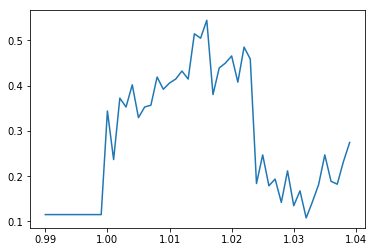

In [27]:
er_r_tab = np.arange(0.99, 1.0391, 0.001)
plt.plot(er_r_tab, acc_tab_er_r)

In [30]:
'''
# XI_I XI_D
xi_i_number = list(range(101, 131, 1))
xi_d_number = list(range(71, 99, 1))
acc_tab_xi = np.zeros(shape=(10,10))
for n_h1 in n_number:
    for n_h2 in n_number:
        parameters, A3 = nn_model(x, y, n_h1, n_h2, er_r = 1.016, xi_i = 1.06, xi_d = 0.77, num_iterations = 4800, learning_rate = 0.01)
        acc = accuracy(output_vec = A3, test_vec = y)
        A3, cache = forward_propagation(xt, parameters)
        acc_t = accuracy(output_vec = A3, test_vec = yt)
        print("{}, {}, {}, {}".format(n_h1, n_h2, acc, acc_t))
        acc_tab[n_h1-1, n_h2-1] = acc*acc_t
''''''

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-30-5a74d98d3eb0>, line 14)